In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager

import corner
import pickle

import binary_c
import xrb
import xrb.src.constants as c
from xrb.binary import binary_evolve
from xrb.src import stats


from xrb.src.core import *
set_data_path("../data")

from xrb.models import HMXB, HMXB_tempering



%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
start = time.time()

sampler = HMXB_tempering.run_emcee_population(nburn=1000, nsteps=1000, nwalkers=80, ntemps=2)

end = time.time()

print "Elapsed time:", int((end-start)/3600), "hours and", (end-start)%3600.0, "seconds"

Setting walkers...
...walkers are set
Starting burn-in...
<generator object sample at 0x7f2a7125dc30>
...finished running burn-in
Starting full run...
...full run finished
Elapsed time: 1 hours and 3427.55248713 seconds


In [6]:
print sampler.chain[0].shape

(80, 1000, 8)


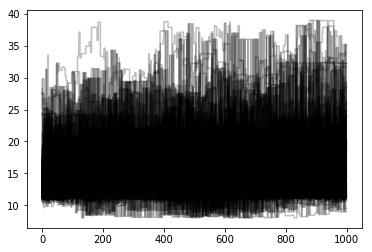

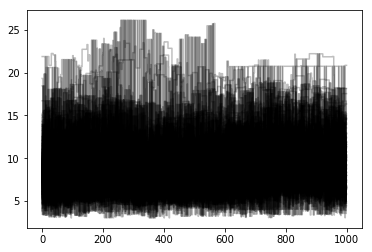

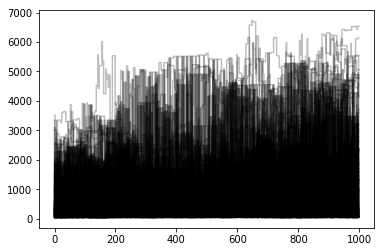

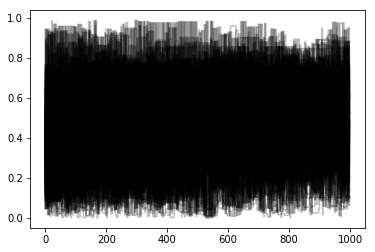

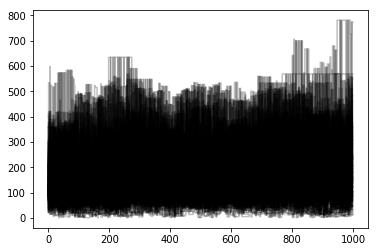

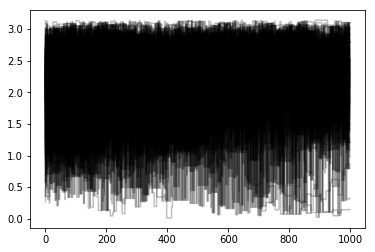

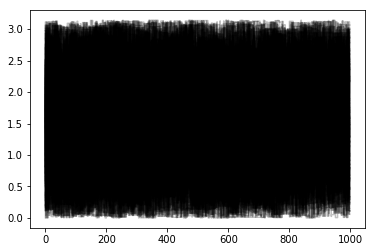

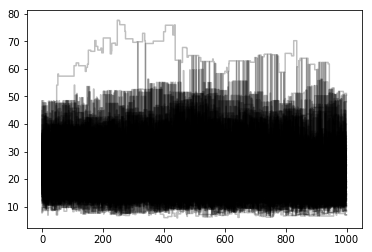

In [8]:
for i in range(sampler.dim):
    plt.figure()
    for chain in sampler.chain[1][...,i]:
        plt.plot(chain, alpha=0.25, color='k', drawstyle='steps')
        
plt.show()

In [4]:
import pickle

pickle.dump(sampler, open("../data/HMXB_population.obj", "wb"))

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


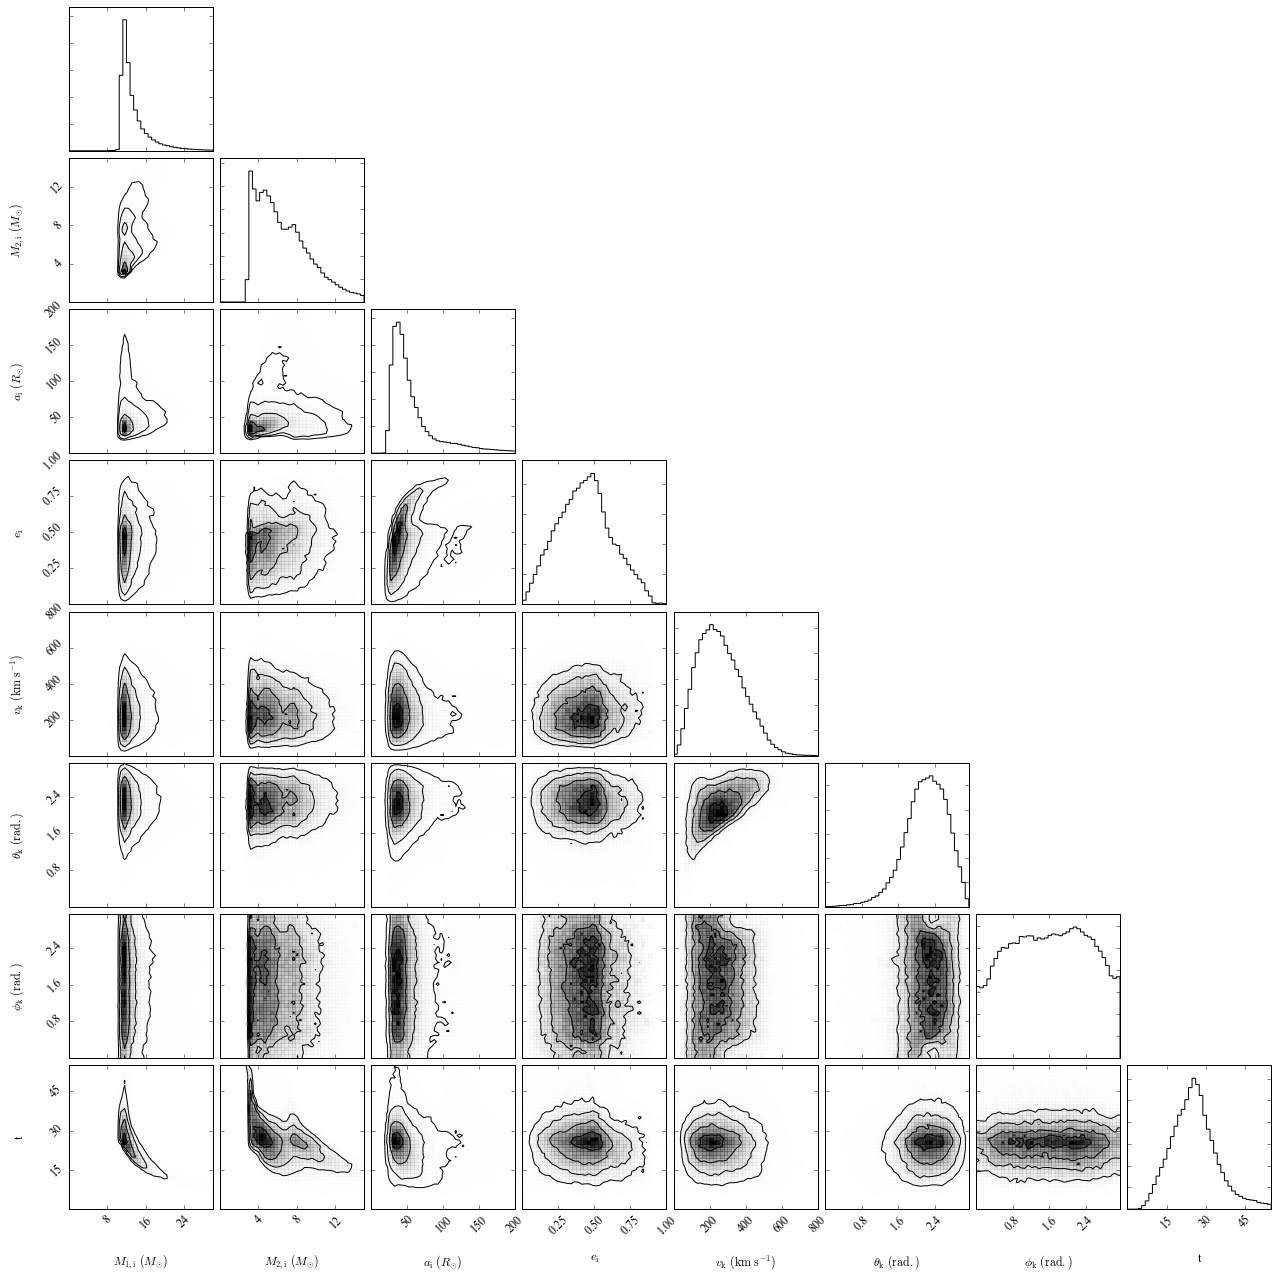

In [5]:
from matplotlib import font_manager
import corner

# Corner plot
fontProperties = {'family':'serif', 'serif':['Times New Roman'], 'weight':'normal', 'size':12}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal', \
                                         weight='normal', stretch='normal', size=12)
plt.rc('font', **fontProperties)

# fig, ax = plt.subplots(10,10, figsize=(10,10))

chain = sampler.flatchain
sampler_data = np.array([10**chain.T[0], 10**chain.T[1], 10**chain.T[2], chain.T[3], \
                         chain.T[4], chain.T[5], chain.T[6], chain.T[7]]).T


labels = [r"$M_{\rm 1, i}\ (M_{\odot})$", r"$M_{\rm 2, i}\ (M_{\odot})$", r"$a_{\rm i}\ (R_{\odot})$", \
          r"$e_{\rm i}$", r"$v_{\rm k}\ ({\rm km}\ {\rm s}^{-1})$", \
          r"$\theta_{\rm k}\ ({\rm rad.})$", r"$\phi_{\rm k}\ ({\rm rad.})$", r"t"]
plt_range = ([0,30], [0,15], [0,200], [0,1], [0,800], [0,np.pi], [0,np.pi], [0, 55.0])


hist2d_kwargs = {"plot_datapoints" : False}
fig = corner.corner(sampler_data, labels=labels, range=plt_range, max_n_ticks=4, bins=40, **hist2d_kwargs)


plt.savefig('../figures/population_HMXB_test_1.pdf', rasterized=True)
# plt.show()

### Now, run the autocorrelation length test

In [2]:
sampler = pickle.load(open("../data/HMXB_population.obj","rb"))

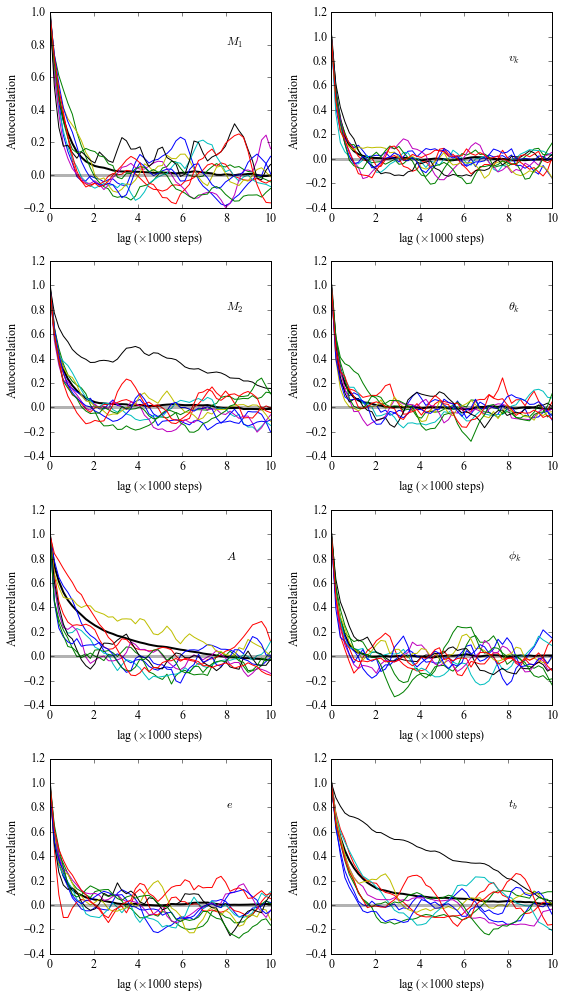

In [8]:
from pandas import Series

fig, ax = plt.subplots(4, 2, figsize=(8,14))

var = [r'$M_1$',r'$M_2$',r'$A$',r'$e$',r'$v_k$',r'$\theta_k$',r'$\phi_k$',r'$t_b$']

N = 50

xmin, xmax = 0, 10000
factor = 1000.0

for k in np.arange(8):
    
    
    kx = k%4
    ky = k/4
    
    # Plot the autocorrelation of the flatchain
    autocorr = np.zeros(N)
    series = Series(data=sampler.flatchain.T[k])
    for i in np.arange(N):
        autocorr[i] = Series.autocorr(series, lag=int(i*float(xmax-xmin)/N))

    ax[kx,ky].plot(np.linspace(xmin,xmax,N)/factor, autocorr, color='k', linewidth=2)

        
    # Plot the autocorrelation of 10 sample chains
    for j in np.arange(10):
        autocorr = np.zeros(N)
        series = Series(data=sampler.chain[j,:,k])

        for i in np.arange(N):
            autocorr[i] = Series.autocorr(series, lag=int(i*float(xmax-xmin)/N))

        ax[kx,ky].plot(np.linspace(xmin,xmax,N)/factor, autocorr)

    
    ax[kx,ky].axhline(0.0, color='k', alpha=0.3, linewidth=3)
    ax[kx,ky].set_xlabel(r'lag ($\times$1000 steps)')
    ax[kx,ky].set_ylabel(r'Autocorrelation')
    ax[kx,ky].text(8, 0.8, var[k])
    
    
plt.tight_layout()

plt.savefig("../figures/HMXB_autocorrelation.pdf")
# plt.show()

In [9]:
metallicity = 0.008


M1_today = np.zeros(len(sampler.flatchain))
M2_today = np.zeros(len(sampler.flatchain))
A_today = np.zeros(len(sampler.flatchain))
ecc_today = np.zeros(len(sampler.flatchain))
v_sys_today = np.zeros(len(sampler.flatchain))
time_SN_1 = np.zeros(len(sampler.flatchain))
P_orb_today = np.zeros(len(sampler.flatchain))



for i, sample in zip(np.arange(len(sampler.flatchain)), sampler.flatchain):
    log_M1, log_M2, log_A, ecc, v_k, theta, phi, t_b = sample
    
    M1 = 10**log_M1
    M2 = 10**log_M2
    A = 10**log_A
    
    
    orbital_period = binary_evolve.A_to_P(M1, M2, A)


    output = binary_c.run_binary(M1, M2, orbital_period, ecc, metallicity, t_b, \
                                 v_k, theta, phi, v_k, theta, phi, 0, 1)


    # Direct from binary_c outputs
    M1_today[i] = output[0]
    M2_today[i] = output[1]
    A_today[i] = output[2]
    ecc_today[i] = output[3]
    v_sys_today[i] = output[4]
    time_SN_1[i] = output[6]
    
    # Orbital period
    P_orb_today[i] = binary_evolve.A_to_P(M1_today[i], M2_today[i], A_today[i])
    
    


In [10]:
data_derived = [M1_today, M2_today, A_today, ecc_today, v_sys_today, time_SN_1, P_orb_today]

In [11]:
pickle.dump(data_derived, open("../data/HMXB_sampler_derived.obj", "wb"))

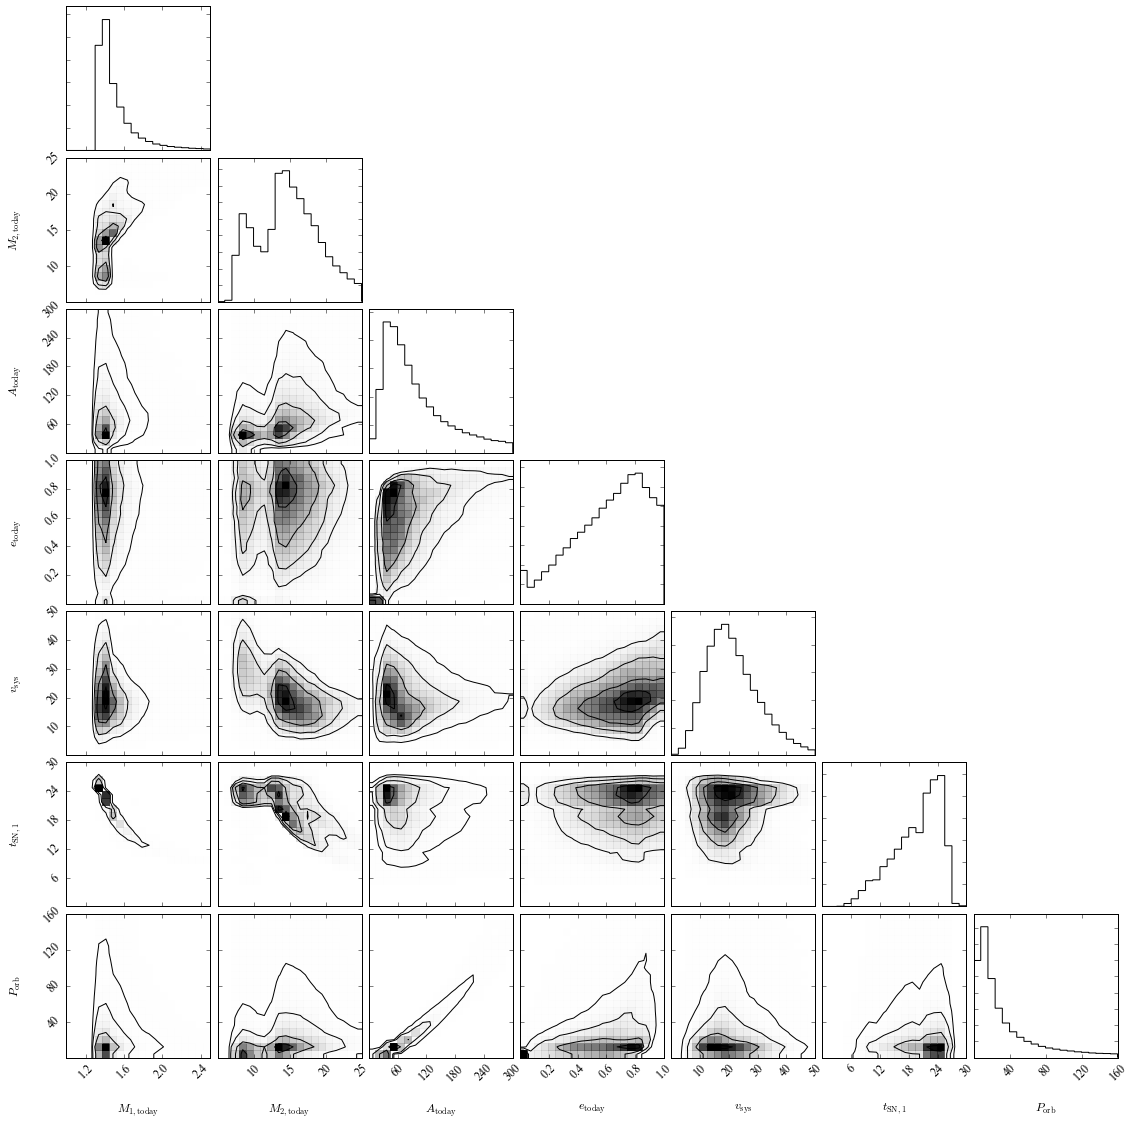

In [14]:
labels = [r"$M_{\rm 1,today}$", r"$M_{\rm 2,today}$", r"$A_{\rm today}$", r"$e_{\rm today}$", 
          r"$v_{\rm sys}$", r"$t_{\rm SN,1}$", r"$P_{\rm orb}$"]
range = [[1.0,2.5], [5,25], [0,300], [0,1], [0,50], [0,30], [0,160]]
hist2d_kwargs = {"plot_datapoints" : False}

corner.corner(np.array(data_derived).T, range=range, labels=labels, **hist2d_kwargs)
plt.savefig("../figures/HMXB_derived.pdf")
# plt.show()